In [1]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

import torch
from scipy.interpolate import interp1d
import scipy.sparse as spa

import grf

from pathlib import Path

FIGURES = Path('figures/PhasePortrait')

FIGURES.mkdir(exist_ok=True, parents=True)

torch.set_grad_enabled(False)

In [2]:
N = 26
lmbda = 1
U1, U2 = np.meshgrid(
    np.linspace(-1.5, 1.5, N),
    np.linspace(-0.5, 0.5, N),
    indexing='xy'
)

In [3]:
V = np.array((U2, -lmbda*(U1**3 - U1)))

In [4]:
C = np.linalg.norm(V, axis=0)

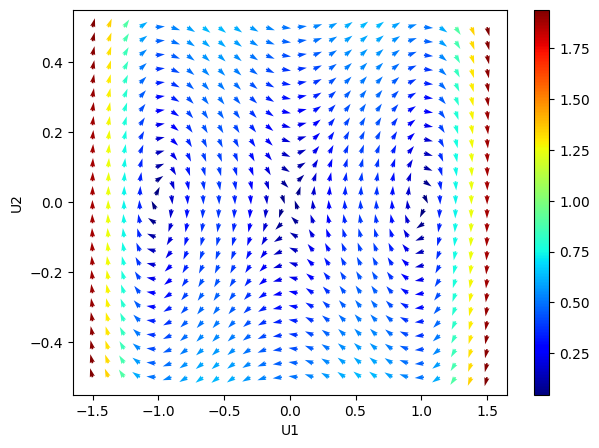

In [5]:
plt.figure(figsize=(7, 5))
plt.quiver(U1, U2, V[0]/C, V[1]/C, C, cmap='jet', width=0.004)
plt.xlabel('U1')
plt.ylabel('U2')
plt.colorbar(aspect=25)
plt.savefig(FIGURES / f'homogeneous_lmbda={lmbda}.png')
plt.show()

In [6]:
def shoot(u0, u1, a0, tmin, tmax, dt, F: callable, DF: callable, max_iter):
    a_next = a0
    n_iter = 0
    while n_iter <= max_iter:
        a_prev = a_next
    
        #  Solve W
        W0 = np.array([u0, a_prev])
        def wF(t, W): return np.array([W[1], F(t, W[0])])
        W = rk3_system(W0, dt, tmin, tmax, wF)

        if abs(W[-1, 0] - u1) <= 1e-8:
            return W, a_next
        
        #  Solve V
        def DFW(t): return DF(0, W[int(t * W.shape[0]), 0])
        def vF(t, V, W=W): return np.array([V[1], DFW(t) * V[0]])
            
        V0 = np.array([0, 1])
        V = rk3_system(V0, dt, tmin, tmax, vF)

        #  Update a
        a_next = a_prev - (W[-1,0] - u1) / V[-1, 0]

        n_iter += 1
    
    if n_iter >= max_iter:
        raise Exception('Failed to converged.')

In [7]:
def rk3_system(x0: np.array, h: float, t_min: float, t_max: float, f: callable):
    xn = x0
    tn = t_min
    steps = [x0]
    while tn <= t_max:
        xi1 = xn
        xi2 = xn + (2/3) * h * f(tn + (2/3)*h, xi1)
        xi3 = xn + (2/3) * h * f(tn + (2/3)*h, xi2)
        
        xn = xn + h * ((1/4)*f(tn,xi1) + (3/8)*f(tn + (2/3)*h, xi2) + (3/8)*f(tn + (2/3)*h, xi3))
        tn = tn + h
        steps.append(xn)
    return np.array(steps)

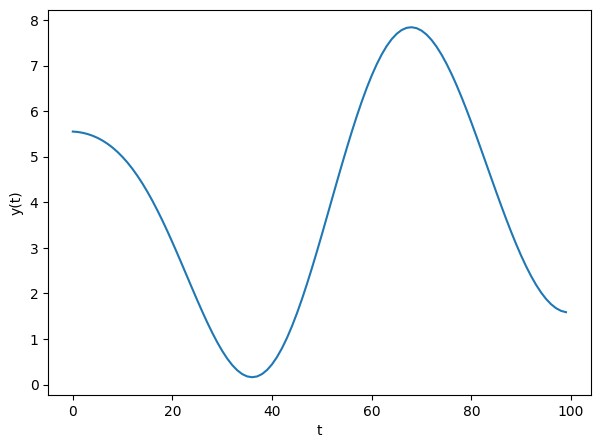

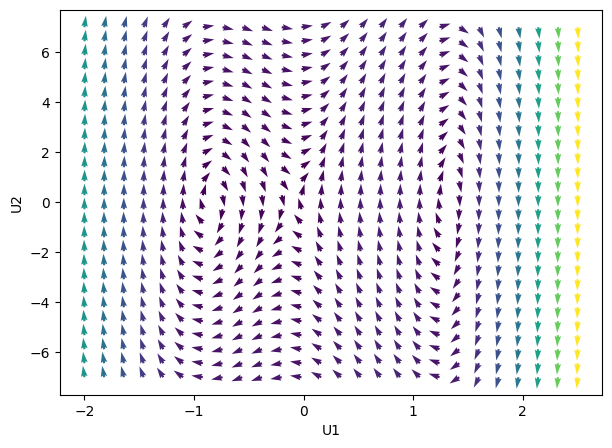

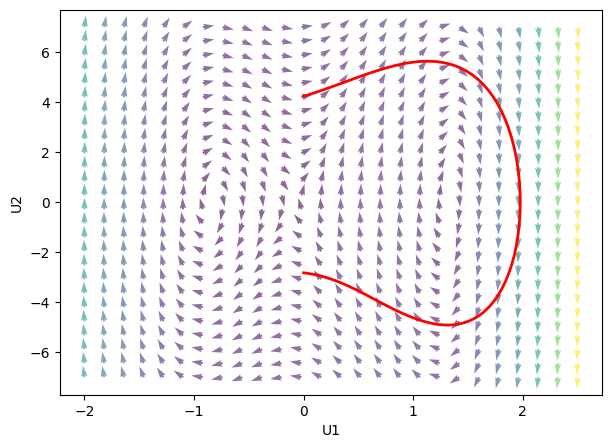

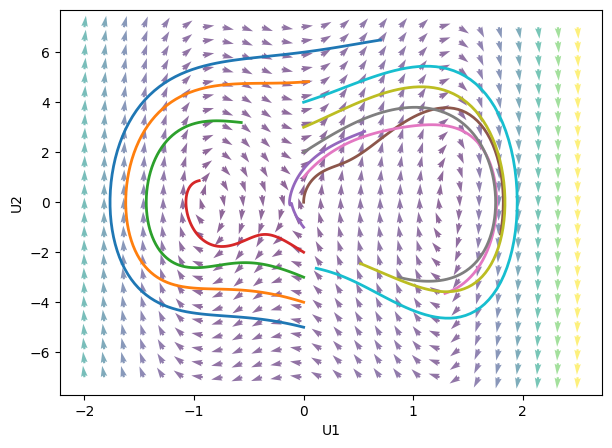

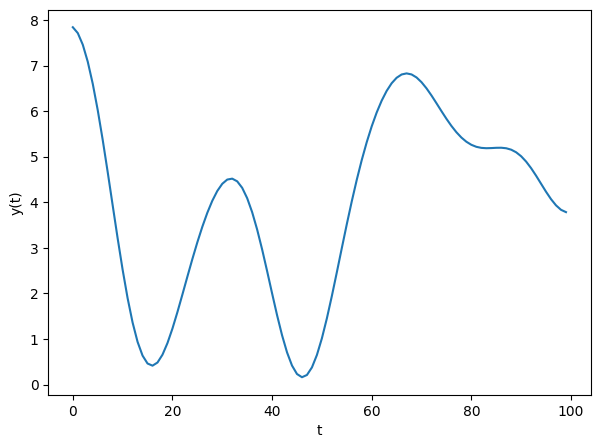

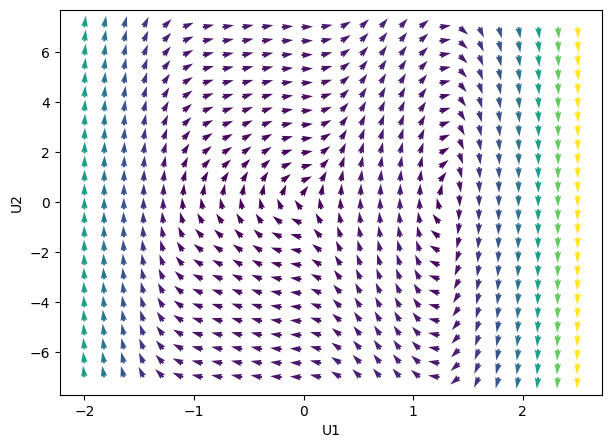

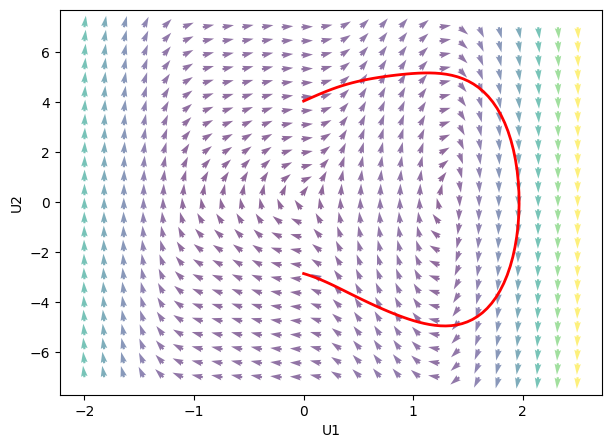

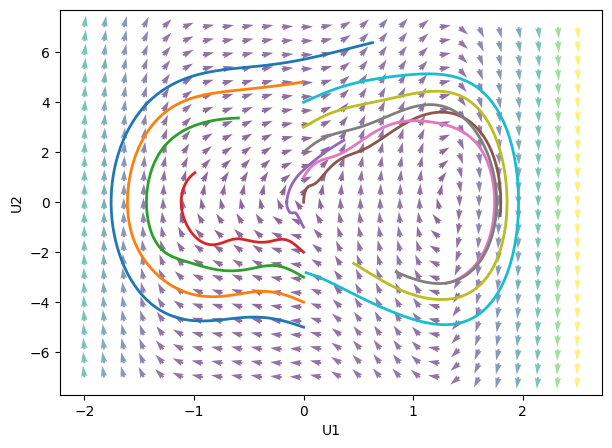

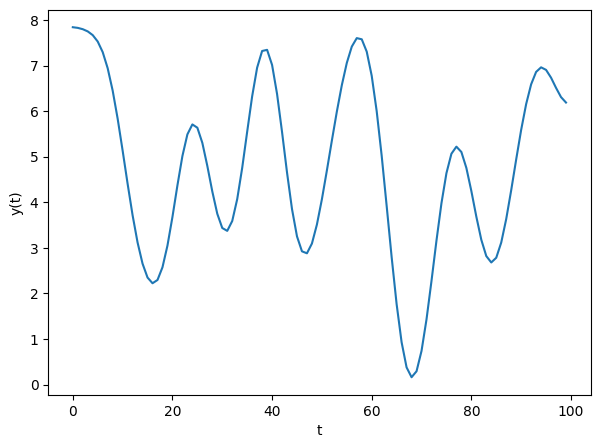

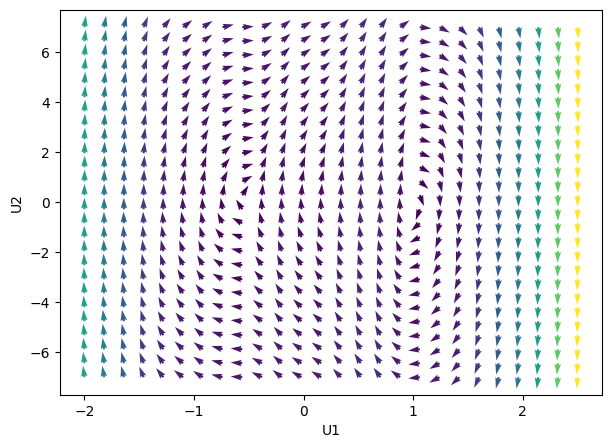

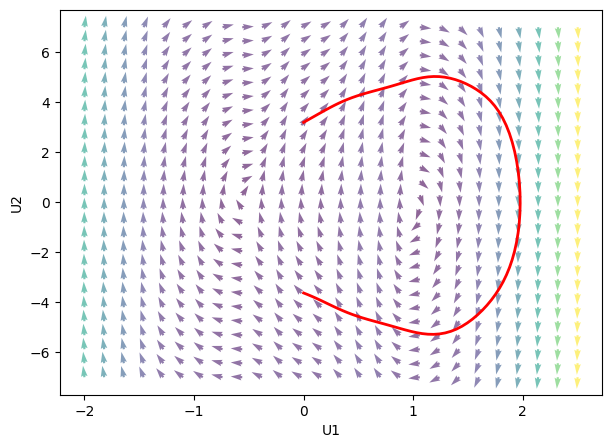

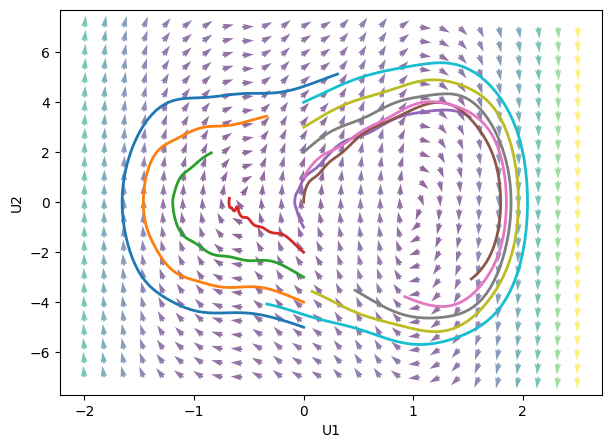

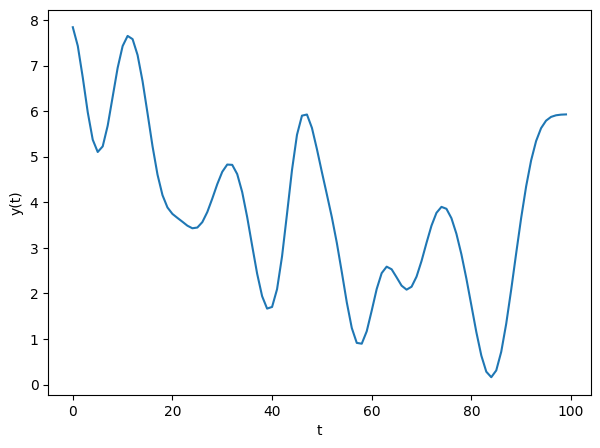

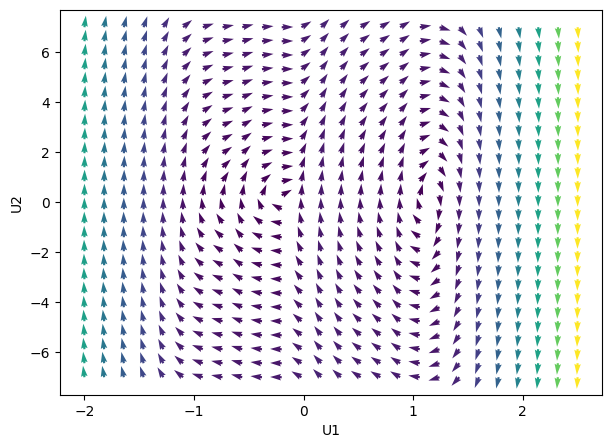

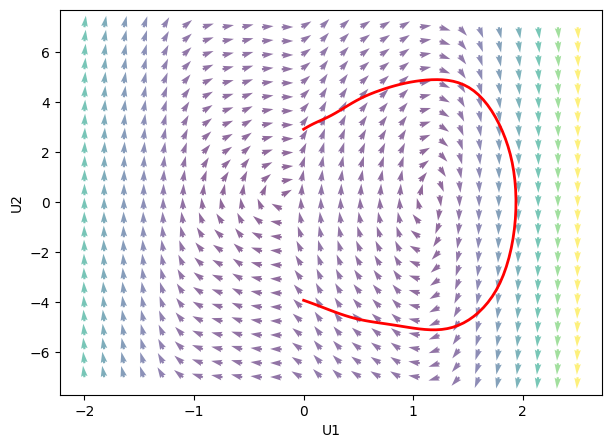

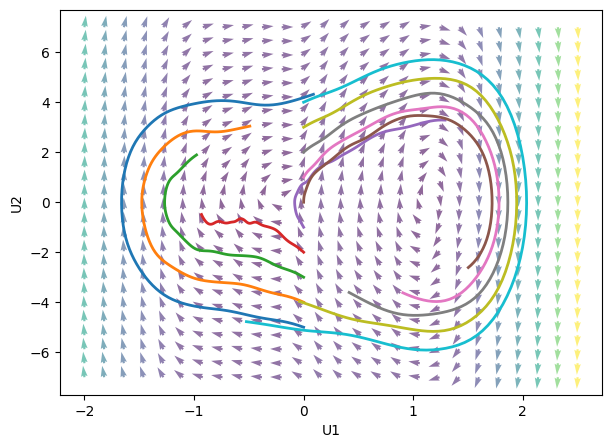

In [9]:
path = 'dataset/ds20k/train/'
train_ds_size = 20000

N = 26
U1, U2 = np.meshgrid(
    np.linspace(-2, 2.5, N),
    np.linspace(-7, 7, N),
    indexing='xy'
)

lmbda = 9
for k, l in enumerate([0.02, 0.05, 0.08, 0.1]):
    y = grf.generate_grf(1, [1.0], [100], lambda m,l=l: grf.RBF(*m, l=l))
    y -= np.min(y)
    y /= np.max(y)
    y = lmbda*(0.96*y + 0.02)
    
    # x = torch.load(path + f'{i}_X.pt').numpy()
    # y = torch.load(path + f'{i}_Y.pt').numpy()
    Yfun = interp1d(np.linspace(0, 1.0, 100), y)
    # Yfun = lambda t: np.sin(2*np.pi*t)
    Y = Yfun(np.linspace(0, 1.0, N))
    
    V = np.array((U2, -lmbda*(U1**3 - U1) + Y))
    C = np.linalg.norm(V, axis=0)

    a0 = 5.0
    u0, u1 = 0.0, 0.0
    tmin, tmax = 0.0, 1.0
    dt = 0.01
    def F(t, U0): return -lmbda*(U0**3 - U0) + Yfun(t)
    def DF(t, U0): return -lmbda*(3*U0**2 - np.ones_like(U0))
    U, a = shoot(u0, u1, a0, tmin, tmax, dt, F, DF, 100)

    #  Plot alone
    plt.figure(figsize=(7, 5))
    plt.plot(y)
    plt.ylabel('y(t)')
    plt.xlabel('t')
    plt.savefig(FIGURES / f'y_{k}.png')
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.quiver(U1, U2, V[0]/C, V[1]/C, C, cmap='viridis', width=0.004)
    plt.xlabel('U1')
    plt.ylabel('U2')
    plt.savefig(FIGURES / f'inhomogeneous_lambda={lmbda}_{k}.png')
    plt.show()

    #  Plot with solution curve
    plt.figure(figsize=(7, 5))
    plt.quiver(U1, U2, V[0]/C, V[1]/C, C, cmap='viridis', width=0.004, alpha=0.6)
    plt.plot(U[:, 0], U[:, 1], '-r', linewidth=2)
    plt.xlabel('U1')
    plt.ylabel('U2')
    plt.savefig(FIGURES / f'inhomogeneous_lambda={lmbda}_{k}_with_curve.png')
    plt.show()

    #  Plot with random trajectories
    plt.figure(figsize=(7, 5))
    plt.quiver(U1, U2, V[0]/C, V[1]/C, C, cmap='viridis', width=0.004, alpha=0.6)
    for j in range(-5, 5, 1):
        U0 = np.array([0, j])
        def f(t, X): return np.array([X[1], F(t, X[0])])
        U = rk3_system(U0, dt, tmin, tmax, f)
        plt.plot(U[:, 0], U[:, 1], linewidth=2)
    plt.xlabel('U1')
    plt.ylabel('U2')
    plt.savefig(FIGURES / f'inhomogeneous_lambda={lmbda}_{k}_with_trajectories.png')
    plt.show()